#**Reduce maintenance cost through predictive techniques:**

## Transcribing the exercise description:

### **Background:**

Company (3D Technologies) has a fleet of devices transmitting daily aggregated telemetry attributes.
Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

### **Goal:**

You are tasked with building a predictive model using machine learning to predict the probability of a device failure. When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.

### **Data:**

Download link: http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv


---

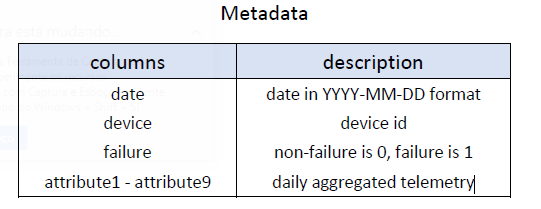

## Planning how to approach the problem before checking the data:

### Some first considerations:

- This is a **classification** problem, so it should be possible to solve with a **supervised learning algorithm**;
- Since one of the concerns is to **minimize false positives and false negatives**, it is important to choose wisely the performance metrics to use to evaluate the models generated;
- At first, the main metrics that come to mind are: **precision, recall, F1-score** and some way to analyse the tradeoff between how much to predict correctly positive and negative outcomes.


### Some initial questions based on the metadata given above:
- What is the best data type for each column?
- Are there any missing values?
- How many observations are there on the dataset?
- How frequent are the failures (proportion of 1's and 0's)?
- How many devices are available on the dataset?
- What is the period of the data (months, years, ...)?

## Beginning of the code section:

### All necessary libraries are reunited on the cell below for better organization:

In [ ]:
# libraries for basic data manipulation:
import numpy as np
import pandas as pd

# libraries to make plots and visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

# libraries related to Machine Learning:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, roc_auc_score

# libraries related to statistics:
import statsmodels.api as sm
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### All necessary functions created are declared on the cell below:

In [ ]:
# add functions here:

# the functions below are used on the bivariate analysis section:

# function to calculate the aggregations (avg, median, min, max and std) to any column:
def get_df_per_att(df, col_name):

    df_per_att = df.groupby(by=['date'], as_index=False).agg({
        'device': ['nunique'],
        col_name: ['mean', 'median', 'min', 'max', 'std']
    })
    df_per_att.columns = df_per_att.columns.droplevel(0)
    df_per_att.columns = ['day', 'distinct_devices', 'avg_value', 'median_value', 'min_value', 'max_value', 'std_value']

    return df_per_att


# function to choose which statistic to visualize all attributes:
def plot_all_attributes(df, statistic):

    fig, axes = plt.subplots(3, 3, figsize=(18,10), squeeze=False)
    fig.suptitle(t='Plot of {} per day'.format(statistic), fontsize=25, ha='center', va='center', y=1.05)

    for col_name, ax in zip(num_cols, axes.flatten()):
        df_temp = get_df_per_att(df, col_name)

        ax.plot(df_temp['day'], df_temp[statistic], color='blue');
        ax.tick_params(axis='x', labelrotation=45);

        ax.plot(df_failure['date'], df_failure[col_name], linestyle='none', marker='x', color='red', markersize=4);

        ax.set_title('Column: {}'.format(str(col_name)), pad=10, fontdict={'fontsize': 15} )

    fig.tight_layout()
    plt.tight_layout()
    plt.show()

### 1 - Obtaining the dataset to use on the rest of the code:



In [ ]:
# location of the dataset provided:
url = 'http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv'

# salving the dataset on a pandas dataframe:
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


***Obs:*** after getting the error shown below, I added the `encoding='ISO-8859-1'` option on `pd.read_csv()` function:

> **UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 95899: invalid start byte**



### 2 - Preparing the dataset (data types and missing values):


- Adjust the data types of each column, if necessary;
- Check for missing values;
- This will answer the first two questions asked before on this [cell](https://colab.research.google.com/drive/1V0AQb8H38J22kTrikEXWSApIdAGYA9TS#scrollTo=TEpMAUZOWfpA&line=1&uniqifier=1).

In [ ]:
# what are the best data types for each column?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [ ]:
# forcing all quantitative variables to a number:
df['attribute1'] = df['attribute1'].astype(int)
df['attribute2'] = df['attribute2'].astype(int)
df['attribute3'] = df['attribute3'].astype(int)
df['attribute4'] = df['attribute4'].astype(int)
df['attribute5'] = df['attribute5'].astype(int)
df['attribute6'] = df['attribute6'].astype(int)
df['attribute7'] = df['attribute7'].astype(int)
df['attribute8'] = df['attribute8'].astype(int)
df['attribute9'] = df['attribute9'].astype(int)
df['failure'] = df['failure'].astype(int)

# changing the date variable to timestamp type:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# checking the data types again to make sure the casting worked:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [ ]:
# are there any missing values?
df.isnull().sum()

# no missing values on any of the columns!!

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

### 3 - Exploratory Data Analysis (EDA):

#### 3.1 - First statistics of the dataset:

In [ ]:
# how many observations are there on the dataset?
df.shape

# almost 125 million observations!!

(124494, 12)

In [ ]:
# how frequent are the failures (proportion of 1's and 0's)?
df['failure'].value_counts(dropna=False)

0    124388
1       106
Name: failure, dtype: int64

In [ ]:
# what is the proportion between 1 and 0?
df['failure'].value_counts(dropna=False, normalize=True)

# more than 99,9% of the observations are of non failures events!!
# failures represent less than 0,1% of the events!!

0    0.999149
1    0.000851
Name: failure, dtype: float64

In [ ]:
# how many devices are available on the dataset?
df['device'].nunique()

# there are 1169 different devices on the dataset!!

1169

In [ ]:
# what is the period of the data (months, years, ...)?
print('First date on the dataset: {}'.format(df['date'].min()))
print('Last date on the dataset: {}'.format(df['date'].max()))

# so there are 10 months of data on the dataset!!

First date on the dataset: 2015-01-01 00:00:00
Last date on the dataset: 2015-11-02 00:00:00


**Initial insights:**


---



---





So now it is possible to answer all questions asked on this [cell](https://colab.research.google.com/drive/1V0AQb8H38J22kTrikEXWSApIdAGYA9TS#scrollTo=TEpMAUZOWfpA&line=1&uniqifier=1):

- **What is the best data type for each column?**

    Integer number for all attributes and target variable, text for device and timestamp for date.


- **Are there any missing values?**

    No missing values on any column of the dataset.


- **How many observations are there on the dataset?**

    There are 124,494 observations.


- **How frequent are the failures (proportion of 1's and 0's)?**

    Failures are much much more infrequent than non failures, so a treatment to deal with the unbalancead dataset will be necessary.

- **How many devices are available on the dataset?**

    There are 1,169 different devices.

- **What is the period of the data (months, years, ...)?**

    From 01/01/2015 to 02/11/2015 (Ten months of data)


#### 3.2 - Descriptive statistics:

In [ ]:
# analysing quantitative and qualitative variables separately:
num_cols = ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5',
            'attribute6', 'attribute7', 'attribute8', 'attribute9']

cat_cols = ['date', 'device']

##### 3.2.1 - Univariate analysis (categorical variables):

In [ ]:
df[cat_cols].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,date,device
count,124494,124494
unique,304,1169
top,2015-01-03 00:00:00,Z1F0QLC1
freq,1163,304
first,2015-01-01 00:00:00,NaN
last,2015-11-02 00:00:00,NaN


In [ ]:
# frequency of observations per date:
df_per_date = df['date'].value_counts(dropna=False)
df_per_date = pd.DataFrame(df_per_date)
df_per_date.reset_index(inplace=True)
df_per_date.columns = ['date', 'frequency']
df_per_date.head(10)

,date,frequency
0,2015-01-03,1163
1,2015-01-01,1163
2,2015-01-02,1163
3,2015-01-04,1162
4,2015-01-05,1161
5,2015-01-06,1054
6,2015-01-07,798
7,2015-01-08,756
8,2015-01-09,756
9,2015-01-12,755


In [ ]:
# distribution of the amount of datapoints per date:

# descriptive statistics:
df_per_date['frequency'].describe()

count     304.000000
mean      409.519737
std       230.762217
min        31.000000
25%       261.000000
50%       350.500000
75%       672.000000
max      1163.000000
Name: frequency, dtype: float64

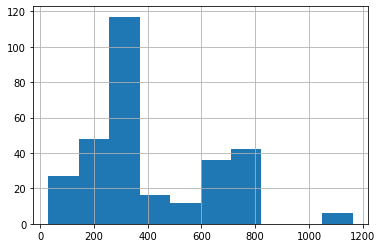

In [ ]:
# histogram:
df_per_date['frequency'].hist(bins=10);

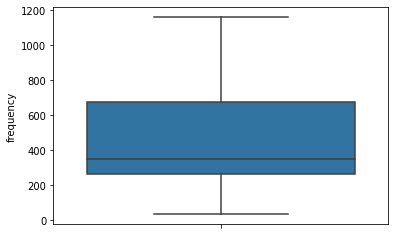

In [ ]:
# boxplot:
sns.boxplot(data=df_per_date, y='frequency');

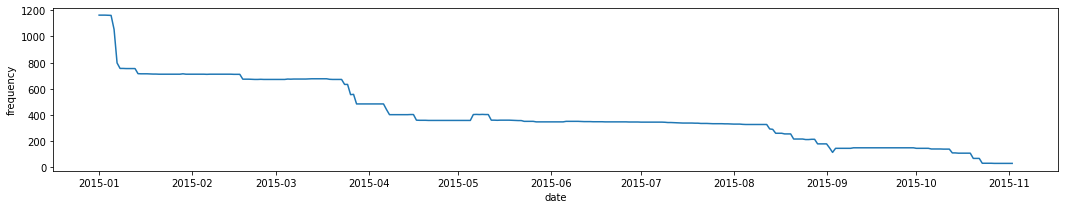

In [ ]:
# as the day passes, how the frequency of datapoints per day chenges?

plt.figure(figsize=(18,3))
sns.lineplot(data=df_per_date, x='date', y='frequency');
plt.show()

**Insights about the datapoints per day:**

- The days do not have the same number of datapoints;
- At the beginning, there are a lot of datapoints, but as the days go by, the number of datapoints per day drops;
- It is important to try to understand the reason for this decrease.

In [ ]:
# frequency of datapoints per device:
df_per_device = df['device'].value_counts(dropna=False)
df_per_device = pd.DataFrame(df_per_device)
df_per_device.reset_index(inplace=True)
df_per_device.columns = ['device', 'frequency']
df_per_device.sample(5)

,device,frequency
490,W1F0VA0G,96
75,S1F118JP,292
748,S1F0P3G2,20
957,S1F02VAX,6
722,W1F0MZRT,48


In [ ]:
# distribution of the frequency of datapoints per device:

# descriptive statistics:
df_per_device['frequency'].describe()

count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: frequency, dtype: float64

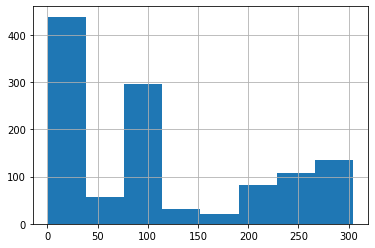

In [ ]:
# histogram:
df_per_device['frequency'].hist(bins=8);

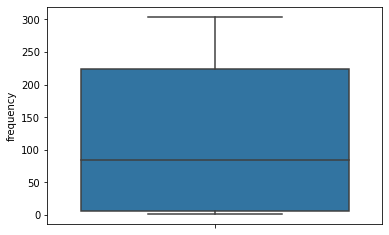

In [ ]:
# boxplot:
sns.boxplot(data=df_per_device, y='frequency');

**Insights about the datapoints per device:**

- The devices do not have the same number of datapoints;
- 25% of them have more than 224 datapoints;
- Half of them have less than 84 datapoints;
- 25% have only 6 or less datapoints;
- This insight needs to be considered during the modeling step, because it could influence how to treat the failures between the devices.

In [ ]:
# now, checking the number of distinct devices for each day:
## BONUS: since the grouping by date, it is possible to calculate the proportion of failures each day:
df_devices_per_date = df.groupby(by=['date'], as_index=False).agg({
    'device': ['count', 'nunique'],
    'failure': ['mean', 'sum']
})
df_devices_per_date.columns = df_devices_per_date.columns.droplevel(0)
df_devices_per_date.columns = ['day', 'num_devices', 'distinct_devices', 'proportion_failures', 'num_failures']
df_devices_per_date

,day,num_devices,distinct_devices,proportion_failures,num_failures
0,2015-01-01,1163,1163,0.000000,0
1,2015-01-02,1163,1163,0.000000,0
2,2015-01-03,1163,1163,0.000000,0
3,2015-01-04,1162,1162,0.000000,0
4,2015-01-05,1161,1161,0.000861,1
...,...,...,...,...,...
299,2015-10-27,31,31,0.000000,0
300,2015-10-29,31,31,0.000000,0
301,2015-10-30,31,31,0.000000,0
302,2015-10-31,31,31,0.000000,0


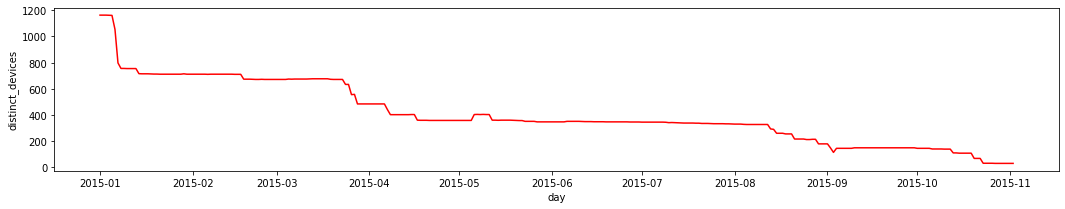

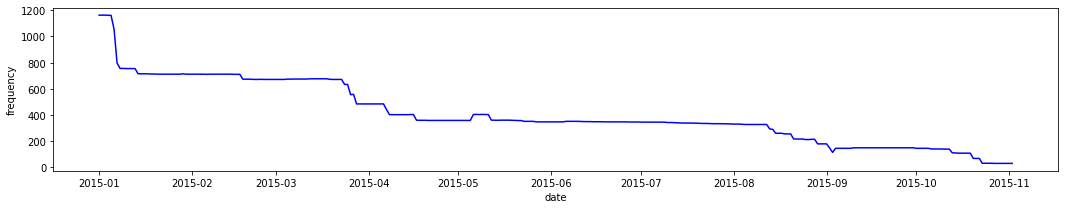

In [ ]:
# as the day passes, how the number of distinct devices per day chenges?
plt.figure(figsize=(18,3))
sns.lineplot(data=df_devices_per_date, x='day', y='distinct_devices', color='red');
plt.show()

# comparing with the number of datapoints per day:
plt.figure(figsize=(18,3))
sns.lineplot(data=df_per_date, x='date', y='frequency', color='blue');
plt.show()

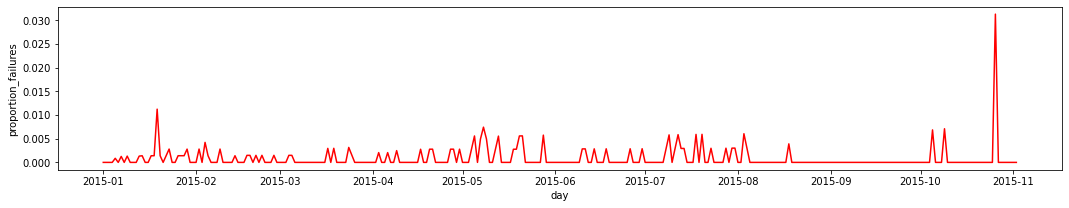

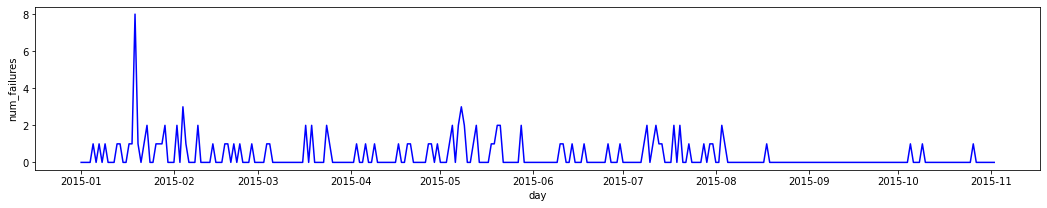

In [ ]:
# proportion of failures per day:

plt.figure(figsize=(18,3))
sns.lineplot(data=df_devices_per_date, x='day', y='proportion_failures', color='red');
plt.show()

# comparing with the number of datapoints per day:
plt.figure(figsize=(18,3))
sns.lineplot(data=df_devices_per_date, x='day', y='num_failures', color='blue');
plt.show()

**Insights about the plots above:**

- As days go by, both number of datapoints and number of distinct devices decreases at the same pace;
- Checking the numbers of failures per day, it is clear that, although the proportion of failures increases at the end of the period, it is because the number of datapoints decreases, so it makes more sense to analyse absolute number of failures per day;
- On the first months, the number of failures are bigger and then it starts to decreases;
- Probably this happens because, as the devices fails, they stop having datapoints on the dataset;
- It is important to check this hypotesis (if the failures events occur always as the last datapoint of each device, than the hypotesis must be true)

##### 3.2.2 - Univariate analysis (numerical variables):

In [ ]:
# descriptive statistics:
df[num_cols].describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


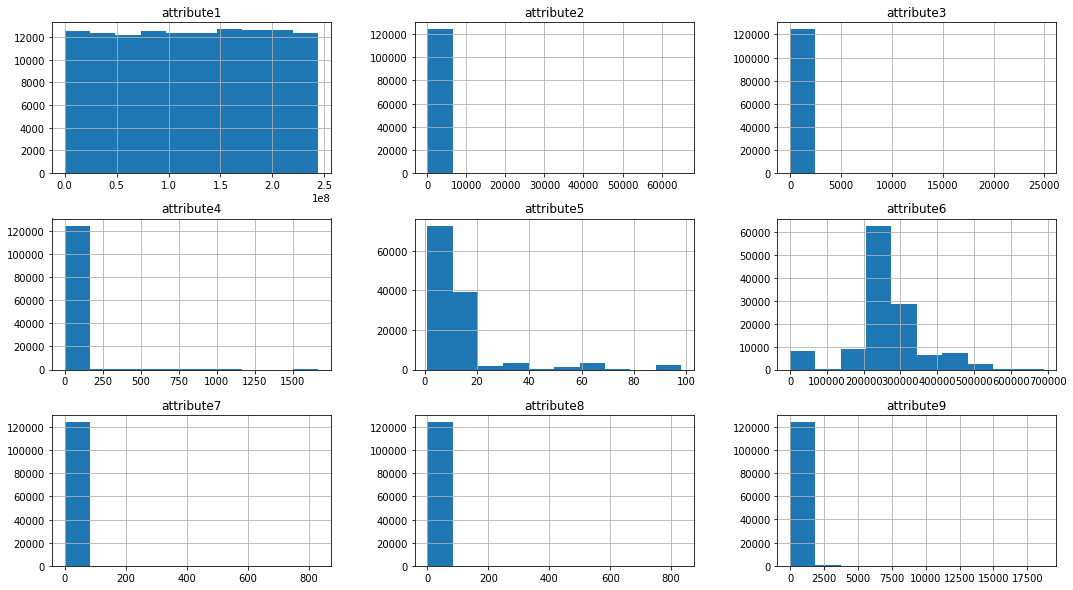

In [ ]:
# histogram:
df[num_cols].hist(figsize=(18,10), bins=10);

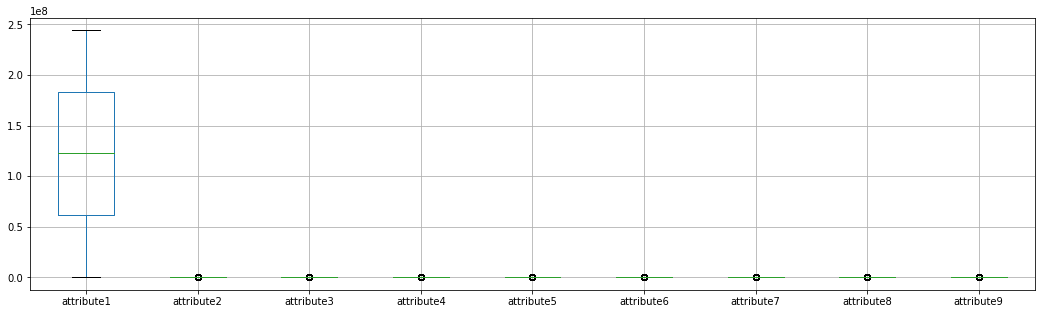

In [ ]:
# boxplot:
df[num_cols].boxplot(figsize=(18,5));

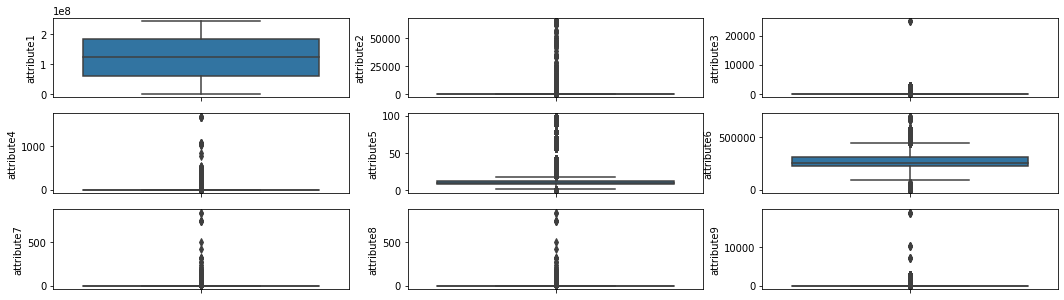

In [ ]:
# trying to visualize boxplot of each attribute separately:
fig, axes = plt.subplots(3, 3, figsize=(18,5))

for col_name, ax in zip(num_cols, axes.flatten()):
    sns.boxplot(data=df, y=col_name, ax=ax);

plt.show()

**Insights about the nine numerical attributes:**

- Attribute1 has a uniform distribution (similar frequency for the entire range of possible values);
- Attribute1 is on a very different scale than the others attributes;
- Attributes 2, 3, 4, 7, 8 and 9 have 75% of their values equal to zero (very skewed to the right);
- Attributes 5 and 6 have non-zero values and less skewed distributions, but each one is on a different scale;

##### 3.2.3 - Bivariate analysis (independent x independent variables):

In [ ]:
# checking the linear correlation between each pair of attributes:

# Pearson's correlation coefficient:
df_cor = df[num_cols].corr(method='pearson')
df_cor

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
attribute1,1.000000,-0.004250,0.003701,0.001836,-0.003376,-0.001522,0.000151,0.000151,0.001121
attribute2,-0.004250,1.000000,-0.002617,0.146593,-0.013999,-0.026350,0.141367,0.141367,-0.002736
attribute3,0.003701,-0.002617,1.000000,0.097452,-0.006696,0.009027,-0.001884,-0.001884,0.532366
attribute4,0.001836,0.146593,0.097452,1.000000,-0.009773,0.024870,0.045631,0.045631,0.036069
attribute5,-0.003376,-0.013999,-0.006696,-0.009773,1.000000,-0.017049,-0.009384,-0.009384,0.005949
attribute6,-0.001522,-0.026350,0.009027,0.024870,-0.017049,1.000000,-0.012207,-0.012207,0.021152
attribute7,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute8,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute9,0.001121,-0.002736,0.532366,0.036069,0.005949,0.021152,0.006861,0.006861,1.000000


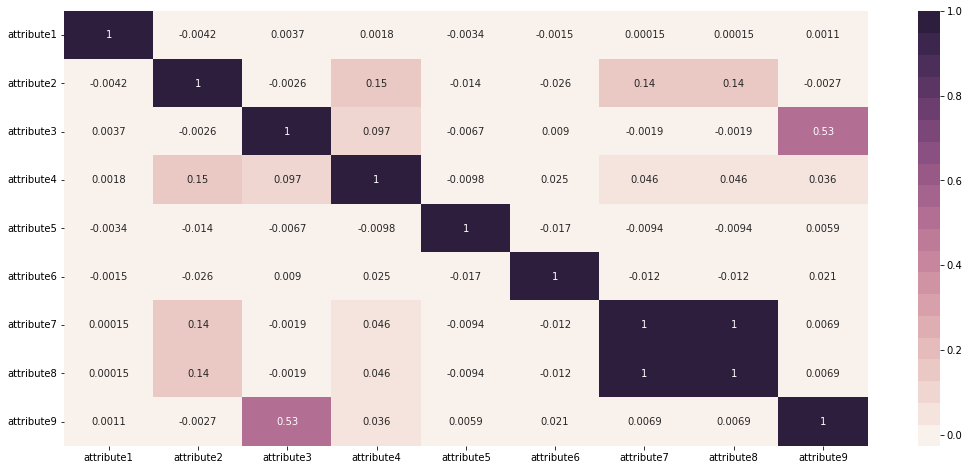

In [ ]:
# analysing with a better visualization (heatmap):
plt.figure(figsize=(18,8))

ax = sns.heatmap( df_cor, annot=True, cmap=sns.cubehelix_palette(20,  light=0.95, dark=0.15) )
ax.xaxis.tick_top
plt.show()

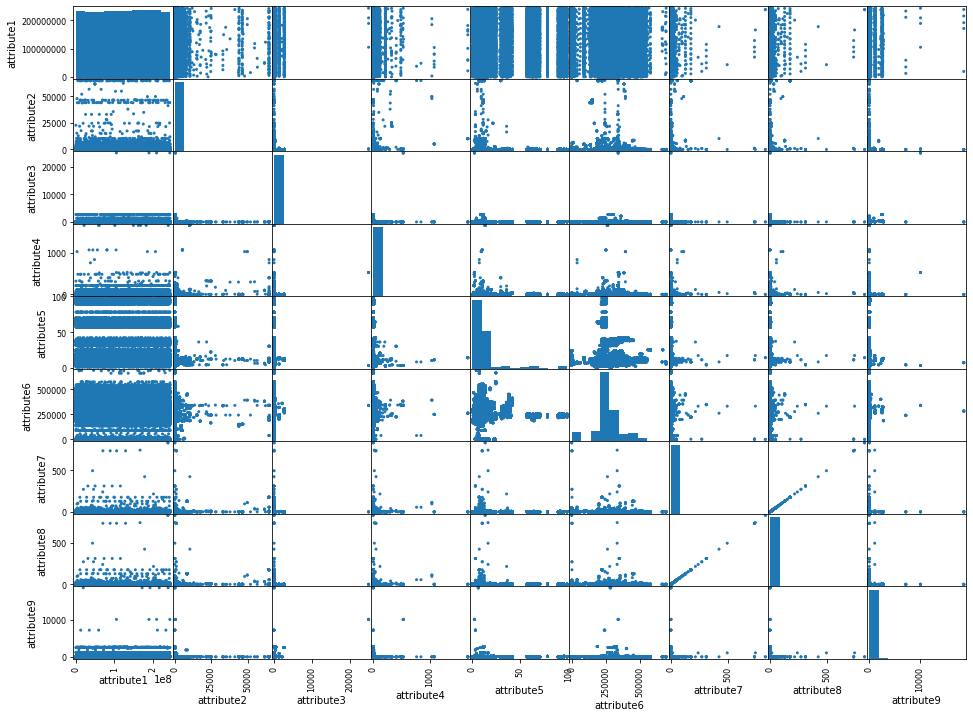

In [ ]:
# visualizing a scatter plot between each pair of attributes:
pd.plotting.scatter_matrix(df[num_cols], alpha=1.0, figsize=(16,12));

**Insights about the correlation between the attributes:**

- Attributes 7 and 8 have a perfect positive linear correlation (ρ = 1), so it is necessary to remove one of them before using on a model to avoid multicolinearity;
- Attributes 3 and 9 seem to have a somewhat linear correlation (ρ = 0.53), but seeing their scatter plot, it is obvious they do not have a linear relationship, so in this case the coefficient is not interpretable;

In [ ]:
# checking aggregated values for the attributes, grouped by day
# trying first for one attribute and then repeat for the rest (functions created are on the functions section):
df_per_att = df.groupby(by=['date'], as_index=False).agg({
    'device': ['nunique'],
    'attribute1': ['mean', 'median', 'min', 'max', 'std']
})
df_per_att.columns = df_per_att.columns.droplevel(0)
df_per_att.columns = ['day', 'distinct_devices', 'avg_value', 'median_value', 'min_value', 'max_value', 'std_value']
df_per_att.head()

,day,distinct_devices,avg_value,median_value,min_value,max_value,std_value
0,2015-01-01,1163,1.221294e+08,123419128,0,244111264,6.995840e+07
1,2015-01-02,1163,1.246089e+08,126292824,370600,244127840,7.030918e+07
2,2015-01-03,1163,1.240456e+08,126424512,636368,244131712,7.017924e+07
3,2015-01-04,1162,1.233935e+08,122728284,543344,243927800,7.092873e+07
4,2015-01-05,1161,1.206756e+08,121285544,4224,243906448,6.994842e+07


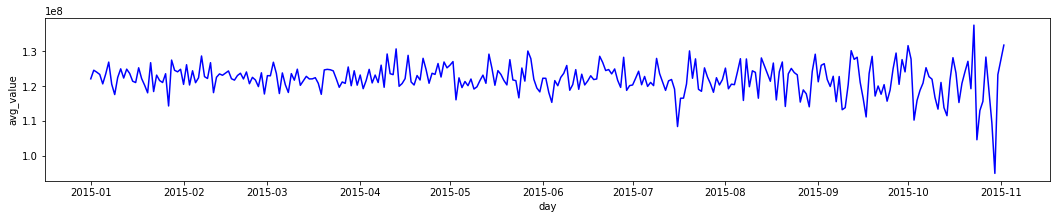

In [ ]:
# checking the average value of the attribute1 per day:
plt.figure(figsize=(18,3))
sns.lineplot(data=df_per_att, x='day', y='avg_value', color='blue');
plt.show()

# what to conclude from this plot?

In [ ]:
# creating a dataframe with only the events with failure to use on the next cell:
df_failure = df.query("failure == 1 ")

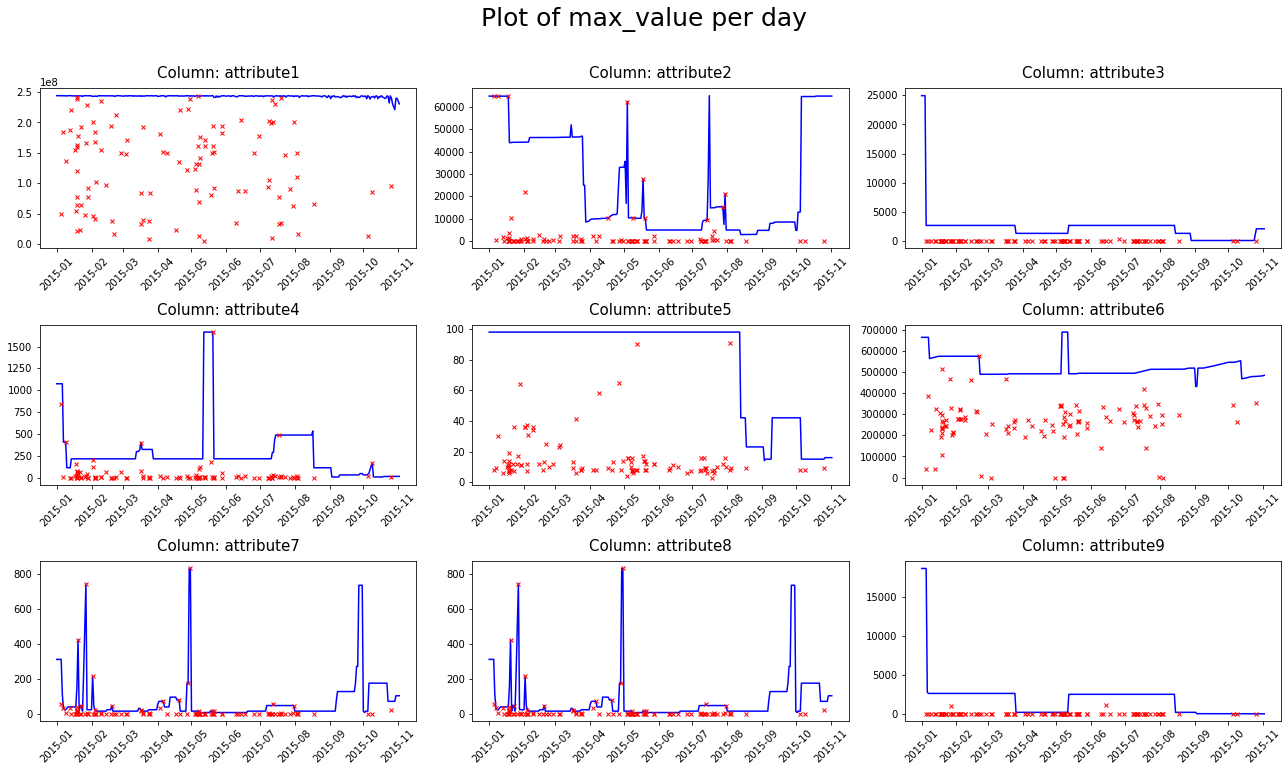

In [ ]:
# now checking the line plot for all attributes:
statistic = 'max_value' # visualizing one statistic at a time: avg, median, min, max and std
plot_all_attributes(df, statistic)

**Insights about the bivariate analysys:**

- Calculating the average, mean, etc of each attribute per day was a good idea, but I do not know exactly how to use so far;
- Plotting the failures on the plot than the average helped to notice that for some of the failures events, the values of some attributes were extreme;
- Seeing the plot with the maximum values helped that some failures almost coincide with peaks for some attributes on some days (examples for the attributes 2, 4, 7 and 8)

##### 3.2.4 - Bivariate analysis (independent x **dependent** variable):

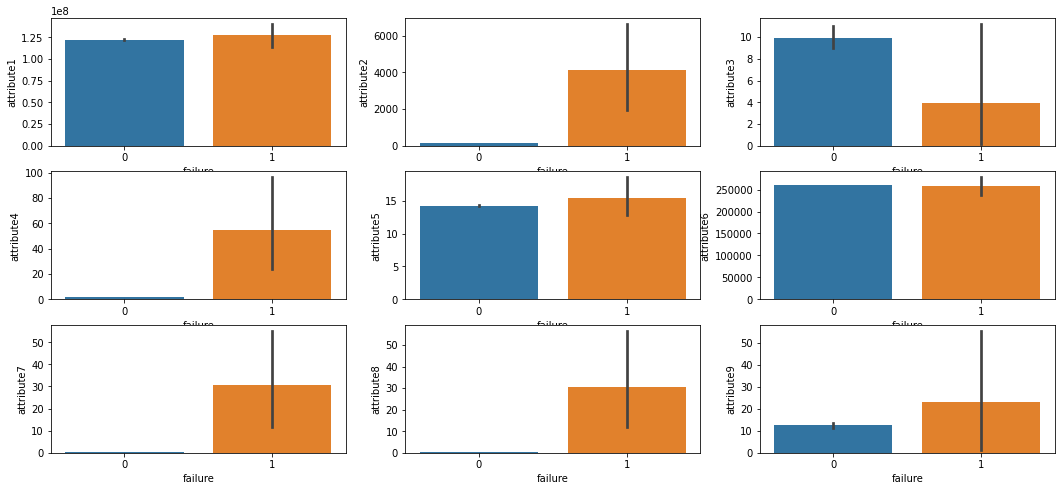

In [ ]:
# how is the ditribution of each attribute when there is a failure x when there is not a failure:

# bar plot:
fig, axes = plt.subplots(3, 3, figsize=(18,8))

for col_name, ax in zip(num_cols, axes.flatten()):
    sns.barplot(data=df, x='failure', y=col_name, ax=ax);

plt.show()

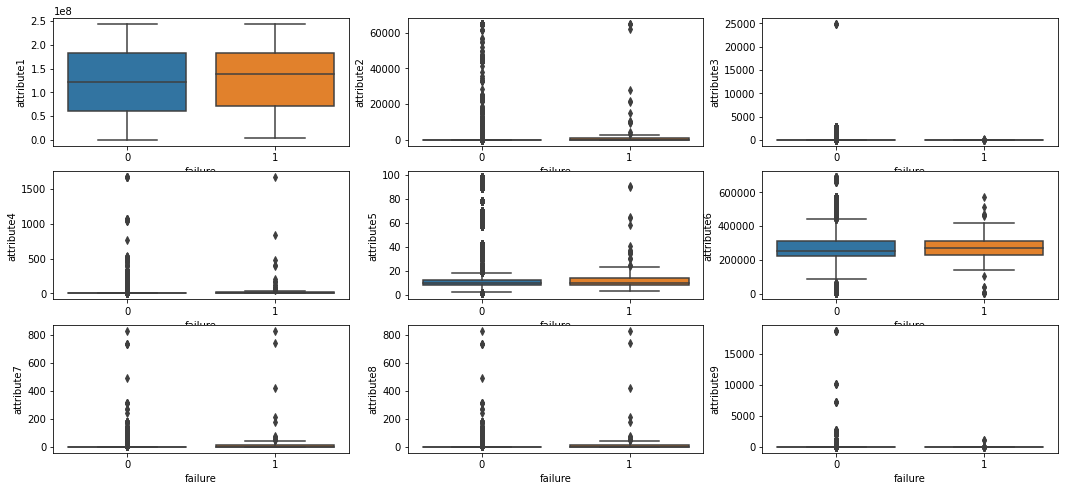

In [ ]:
# boxplot:
fig, axes = plt.subplots(3, 3, figsize=(18,8))

for col_name, ax in zip(num_cols, axes.flatten()):
    sns.boxplot(data=df, x='failure', y=col_name, ax=ax);

plt.show()

**Insights about the distribution of the attributes with and without failire:**

- Boxplots were not very insightful, the only thing it was possible to notice is that there are a lot of outliers, both with and without failures;
- Barplots were useful to notice differences on the distribution of some attributes for the events with failure and without failure;
- Attributes 2, 4, 7, 8 and 9 seem to have a relation with the failure, because, the failures tend to have higher values for these attributes than the non-failures;
- Similar to attribute 3, but the opposite: failures have lower values of this attribute, compared with non-failures

#### 3.3 - Feature engineering:

In [ ]:
# before creating new features, it is important to remove attributes with a strong linear correlation:

# as seen on the EDA section, attributes 7 and 8 are perfectly correlated,
# so it is necessary to remove on of them:

# creating a copy of the original dataframe:
df_feature_eng = df.copy()

# removing attribute8:
df_feature_eng.drop('attribute8', axis=1, inplace=True)

num_cols.remove('attribute8')

In [ ]:
# creating a feature with number of days in operation:
df_feature_eng['days_operation'] = (df_feature_eng['date'] - df_feature_eng['date'].min()).dt.days
df_feature_eng.sample(5)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,days_operation
24748,2015-01-31,W1F0WK71,0,186040208,0,0,0,6,263764,0,0,30
44571,2015-03-01,S1F0GSD9,0,3444800,0,0,0,12,225012,0,0,59
84068,2015-05-21,W1F14FS4,0,141741984,0,0,0,6,258189,0,0,140
45260,2015-03-02,S1F0LCVC,0,69840184,0,0,0,8,218968,0,0,60
104857,2015-07-20,W1F0HNC5,0,242876752,0,0,0,59,248526,0,1,200


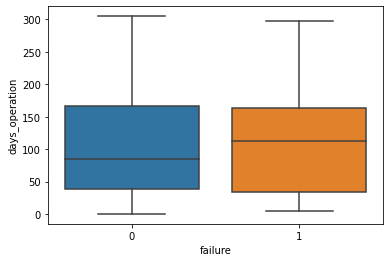

In [ ]:
sns.boxplot(data=df_feature_eng, x='failure', y='days_operation');

In [ ]:
# creating a feature with the value of each attribute on the day before (D-1):

# sorting by device first and then date:
df_feature_eng = df_feature_eng.sort_values(by=['device', 'date'])

df_feature_eng['attribute1_d1'] = df_feature_eng['attribute1'].shift(1)
df_feature_eng['attribute2_d1'] = df_feature_eng['attribute2'].shift(1)
df_feature_eng['attribute3_d1'] = df_feature_eng['attribute3'].shift(1)
df_feature_eng['attribute4_d1'] = df_feature_eng['attribute4'].shift(1)
df_feature_eng['attribute5_d1'] = df_feature_eng['attribute5'].shift(1)
df_feature_eng['attribute6_d1'] = df_feature_eng['attribute6'].shift(1)
df_feature_eng['attribute7_d1'] = df_feature_eng['attribute7'].shift(1)
#df_feature_eng['attribute8_d1'] = df_feature_eng['attribute8'].shift(1)
df_feature_eng['attribute9_d1'] = df_feature_eng['attribute9'].shift(1)

# this way, the shift will mix one device to the next!!
# trying something to solve this...

In [ ]:
# list of devices sorted alphabetically:
list_of_devices = df['device'].unique().tolist()
list_of_devices.sort()
list_of_devices[:5]

['S1F01085', 'S1F013BB', 'S1F0166B', 'S1F01E6Y', 'S1F01JE0']

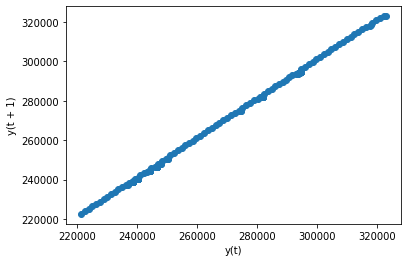

In [ ]:
# checking the best lag window to choose:

# choosing arbitrary devices and attributes to visualize on a lag plot...
# trying some combinations of device and attribute:
pd.plotting.lag_plot(df_feature_eng.query("device == 'S1F13MAM' ")['attribute6'], lag=1);

# it seems that the value of the day before is highly correlated with the present day (auto-correlated) for some of the attributes
# the D-1 feature seems to be a good addition to the dataset

In [ ]:
# to prevent the last value of a device be shifted to the first occurrence of the next device:
# loop through the devices to make the shift for each one separately:
# then loop through the attributes to shift for all of them:
for device in list_of_devices:

    for col in num_cols:

        df_feature_eng.loc[df_feature_eng['device']==device,'{}_d1'.format(col)] = \
            df_feature_eng.loc[df_feature_eng['device']==device, col].shift(1)


In [ ]:
# checking if it worked:
df_feature_eng[['device', 'date', 'attribute1', 'attribute1_d1', 'attribute2', 'attribute2_d1']].head(20)

# YES!! :)

,device,date,attribute1,attribute1_d1,attribute2,attribute2_d1
0,S1F01085,2015-01-01,215630672,NaN,56,NaN
1163,S1F01085,2015-01-02,1650864,215630672.0,56,56.0
2326,S1F01085,2015-01-03,124017368,1650864.0,56,56.0
3489,S1F01085,2015-01-04,128073224,124017368.0,56,56.0
4651,S1F01085,2015-01-05,97393448,128073224.0,56,56.0
5812,S1F01085,2015-01-06,128832128,97393448.0,56,56.0
78172,S1F013BB,2015-05-06,14533968,NaN,0,NaN
78576,S1F013BB,2015-05-07,46202296,14533968.0,0,0.0
78981,S1F013BB,2015-05-08,214383720,46202296.0,0,0.0
79385,S1F013BB,2015-05-09,243346080,214383720.0,0,0.0


In [ ]:
# applying the same idea to create a feature with the moving average:
# doing only for a 7-day moving average, but later, it is possible to create for new windows of time:
for device in list_of_devices:

    for col in num_cols:

        df_feature_eng.loc[df_feature_eng['device']==device,'{}_mov_avg_7'.format(col)] = \
            df_feature_eng.loc[df_feature_eng['device']==device, col].rolling(7).mean()


In [ ]:
# checking if it worked:
df_feature_eng[['device', 'date', 'attribute1', 'attribute1_d1', 'attribute1_mov_avg_7']].head(30)

# YES!! :)

,device,date,attribute1,attribute1_d1,attribute1_mov_avg_7
0,S1F01085,2015-01-01,215630672,NaN,NaN
1163,S1F01085,2015-01-02,1650864,215630672.0,NaN
2326,S1F01085,2015-01-03,124017368,1650864.0,NaN
3489,S1F01085,2015-01-04,128073224,124017368.0,NaN
4651,S1F01085,2015-01-05,97393448,128073224.0,NaN
5812,S1F01085,2015-01-06,128832128,97393448.0,NaN
78172,S1F013BB,2015-05-06,14533968,NaN,NaN
78576,S1F013BB,2015-05-07,46202296,14533968.0,NaN
78981,S1F013BB,2015-05-08,214383720,46202296.0,NaN
79385,S1F013BB,2015-05-09,243346080,214383720.0,NaN


In [ ]:
# after these operations, there are some NaN values caused by the shift and the rolling:
df_feature_eng.isnull().sum()

date                       0
device                     0
failure                    0
attribute1                 0
attribute2                 0
attribute3                 0
attribute4                 0
attribute5                 0
attribute6                 0
attribute7                 0
attribute9                 0
days_operation             0
attribute1_d1           1169
attribute2_d1           1169
attribute3_d1           1169
attribute4_d1           1169
attribute5_d1           1169
attribute6_d1           1169
attribute7_d1           1169
attribute9_d1           1169
attribute1_mov_avg_7    6898
attribute2_mov_avg_7    6898
attribute3_mov_avg_7    6898
attribute4_mov_avg_7    6898
attribute5_mov_avg_7    6898
attribute6_mov_avg_7    6898
attribute7_mov_avg_7    6898
attribute9_mov_avg_7    6898
dtype: int64

In [ ]:
df_feature_eng.interpolate(method='linear', inplace=False, )

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,days_operation,attribute1_d1,attribute2_d1,attribute3_d1,attribute4_d1,attribute5_d1,attribute6_d1,attribute7_d1,attribute9_d1,attribute1_mov_avg_7,attribute2_mov_avg_7,attribute3_mov_avg_7,attribute4_mov_avg_7,attribute5_mov_avg_7,attribute6_mov_avg_7,attribute7_mov_avg_7,attribute9_mov_avg_7
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,1,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,2,1650864.0,56.0,0.0,52.0,6.0,407438.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,3,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,4,128073224.0,56.0,0.0,52.0,6.0,407439.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65334,2015-04-02,Z1F2PBHX,0,180917784,0,0,0,5,162645,0,0,91,232559640.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,1.404670e+08,0.0,0.0,0.0,5.0,162574.428571,0.0,0.0
65819,2015-04-03,Z1F2PBHX,0,33952520,0,0,0,5,162645,0,0,92,180917784.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,1.415234e+08,0.0,0.0,0.0,5.0,162645.000000,0.0,0.0
66304,2015-04-04,Z1F2PBHX,0,59053184,0,0,0,5,162645,0,0,93,33952520.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,1.229845e+08,0.0,0.0,0.0,5.0,162645.000000,0.0,0.0
66789,2015-04-05,Z1F2PBHX,0,110545440,0,0,0,5,163047,0,0,94,59053184.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,1.212694e+08,0.0,0.0,0.0,5.0,162702.428571,0.0,0.0


In [ ]:
# removing all of these datapoints is not a good idea, so instead,
# an option is to use pandas backfill method to propagate the values to the NaN "gaps":

df_feature_eng.fillna(value=None, method='backfill', axis=0, inplace=True) # use next valid observation to fill gap

In [ ]:
# checking if it worked:
df_feature_eng[['device', 'date', 'attribute1', 'attribute1_d1', 'attribute1_mov_avg_7']].head(30)

# YES!! :)

,device,date,attribute1,attribute1_d1,attribute1_mov_avg_7
0,S1F01085,2015-01-01,215630672,215630672.0,1.333817e+08
1163,S1F01085,2015-01-02,1650864,215630672.0,1.333817e+08
2326,S1F01085,2015-01-03,124017368,1650864.0,1.333817e+08
3489,S1F01085,2015-01-04,128073224,124017368.0,1.333817e+08
4651,S1F01085,2015-01-05,97393448,128073224.0,1.333817e+08
5812,S1F01085,2015-01-06,128832128,97393448.0,1.333817e+08
78172,S1F013BB,2015-05-06,14533968,14533968.0,1.333817e+08
78576,S1F013BB,2015-05-07,46202296,14533968.0,1.333817e+08
78981,S1F013BB,2015-05-08,214383720,46202296.0,1.333817e+08
79385,S1F013BB,2015-05-09,243346080,214383720.0,1.333817e+08


In [ ]:
# checking if all NaN values are gone:
df_feature_eng.isnull().sum()

# YES!! :)

date                    0
device                  0
failure                 0
attribute1              0
attribute2              0
attribute3              0
attribute4              0
attribute5              0
attribute6              0
attribute7              0
attribute9              0
days_operation          0
attribute1_d1           0
attribute2_d1           0
attribute3_d1           0
attribute4_d1           0
attribute5_d1           0
attribute6_d1           0
attribute7_d1           0
attribute9_d1           0
attribute1_mov_avg_7    0
attribute2_mov_avg_7    0
attribute3_mov_avg_7    0
attribute4_mov_avg_7    0
attribute5_mov_avg_7    0
attribute6_mov_avg_7    0
attribute7_mov_avg_7    0
attribute9_mov_avg_7    0
dtype: int64

In [ ]:
# creating a feature from the initial letters of the device name:
df_feature_eng['device_initials'] = df_feature_eng['device'].apply(lambda x: x[:4])
df_feature_eng.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,days_operation,attribute1_d1,attribute2_d1,attribute3_d1,attribute4_d1,attribute5_d1,attribute6_d1,attribute7_d1,attribute9_d1,attribute1_mov_avg_7,attribute2_mov_avg_7,attribute3_mov_avg_7,attribute4_mov_avg_7,attribute5_mov_avg_7,attribute6_mov_avg_7,attribute7_mov_avg_7,attribute9_mov_avg_7,device_initials
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,7.0,1.333817e+08,0.0,0.0,0.0,12.0,241290.285714,0.0,0.0,S1F0
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,1,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,7.0,1.333817e+08,0.0,0.0,0.0,12.0,241290.285714,0.0,0.0,S1F0
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,2,1650864.0,56.0,0.0,52.0,6.0,407438.0,0.0,7.0,1.333817e+08,0.0,0.0,0.0,12.0,241290.285714,0.0,0.0,S1F0
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,3,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,7.0,1.333817e+08,0.0,0.0,0.0,12.0,241290.285714,0.0,0.0,S1F0
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,4,128073224.0,56.0,0.0,52.0,6.0,407439.0,0.0,7.0,1.333817e+08,0.0,0.0,0.0,12.0,241290.285714,0.0,0.0,S1F0


In [ ]:
# checking the statistics for each initial:
df_feature_eng.groupby('device_initials', as_index=False).agg({
    'device': ['count', 'nunique', 'min', 'max']
})

# it seems that a lot of devices have the first 4 letters in common
# my guess is that maybe it is some type of classification or brand or category

device_initials device                            
                   count nunique       min       max
0            S1F0  33169     391  S1F01085  S1F0YX6Z
1            S1F1  21689     139  S1F100R5  S1F13MAM
2            W1F0  23294     282  W1F00CL9  W1F0ZVD8
3            W1F1  19974     138  W1F10Y8K  W1F1ZVME
4            Z1F0  18869     149  Z1F02KDL  Z1F0ZCPW
5            Z1F1   7248      67  Z1F118C9  Z1F1VQFY
6            Z1F2    251       3  Z1F26YZB  Z1F2PBHX

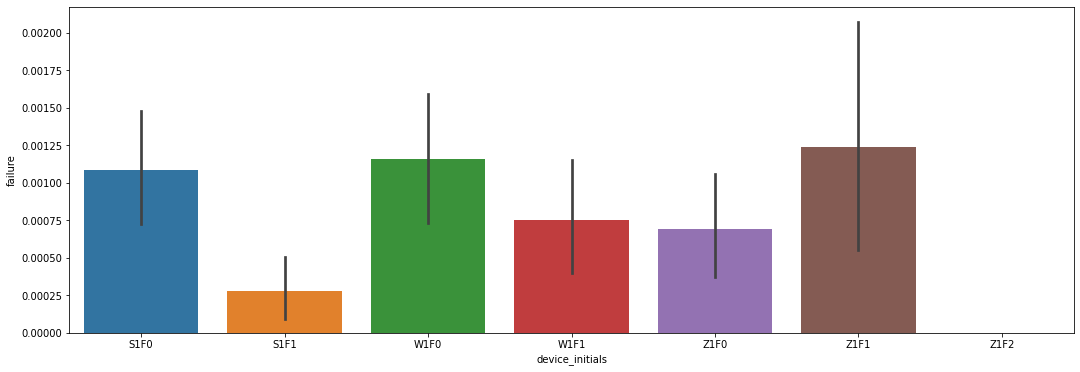

In [ ]:
# checking the proportion of failures for each "group" of devices:
plt.figure(figsize=(18,6))
sns.barplot(data=df_feature_eng, x='device_initials', y='failure', estimator=np.mean);

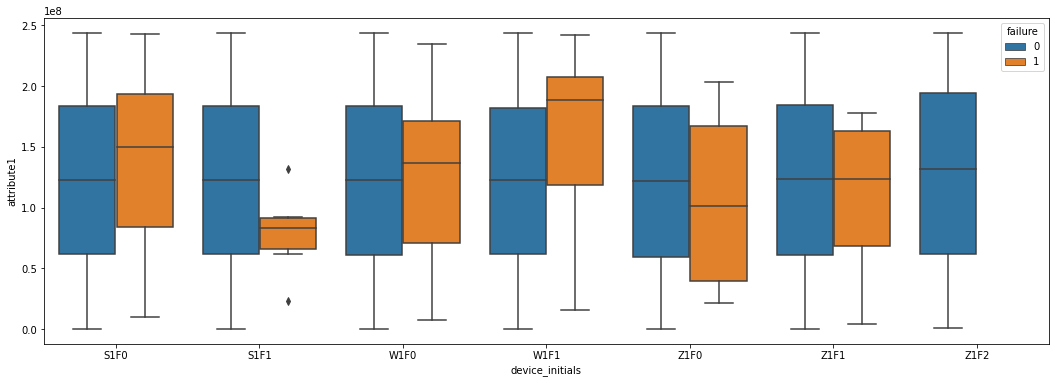

In [ ]:
# visualizing a boxplot:
plt.figure(figsize=(18,6))
sns.boxplot(data=df_feature_eng, x='device_initials', y='attribute1', hue='failure');

**Insights about the features created:**

- I have a feeling that the feature 'days_operation' will be helpful;
- The time-based features carry important information about what happened before each event, which seems also that will be helpful;
- The feature 'device_initials' was I wild guess from my part, but at the end, maybe it will be important for the model.

### 4 - Preprocessing the dataset:

#### 4.1 - Spliting the dataset in train, validation and test sets:

In [ ]:
# splitting the dataset to be able to evaluate the performance of the models:

# using only the numerical variables for now (I chose not to use the device_initials at first):
X = df_feature_eng.drop(['date', 'failure', 'device', 'device_initials'], axis=1, inplace=False)

# failure is the target variable (y):
y = df_feature_eng['failure']

# using a function from sklearn to make the split (first only in train and test):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# checking if the shape of each dataset is correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(93370, 25)
(93370,)
(31124, 25)
(31124,)


In [ ]:
# checking how is the proportion of failures / nono-failures:
print('Absolute values:')
print('')
print('y:')
print(y.value_counts(normalize=False))

print('')
print('y_train:')
print(y_train.value_counts(normalize=False))

print('')
print('y_test:')
print(y_test.value_counts(normalize=False))

print('')
print('===================')
print('Proportion:')
print('')

print('y:')
print(y.value_counts(normalize=True))

print('')
print('y_train:')
print(y_train.value_counts(normalize=True))

print('')
print('y_test:')
print(y_test.value_counts(normalize=True))

# train and test sets have the same proportion of the classes!!

Absolute values:

y:
0    124388
1       106
Name: failure, dtype: int64

y_train:
0    93292
1       78
Name: failure, dtype: int64

y_test:
0    31096
1       28
Name: failure, dtype: int64

Proportion:

y:
0    0.999149
1    0.000851
Name: failure, dtype: float64

y_train:
0    0.999165
1    0.000835
Name: failure, dtype: float64

y_test:
0    0.9991
1    0.0009
Name: failure, dtype: float64


#### 4.2 - Oversampling the dataset to minimize the effect of the unbalanced frequency of failures x non-failures:

Some links that were used as inspiration for the code on this section:
- https://stackoverflow.com/questions/51064462/process-for-oversampling-data-for-imbalanced-binary-classification
- https://stackoverflow.com/questions/48805063/balance-classes-in-cross-validation/48810493#48810493
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [ ]:
# since the dataset is very unbalanced (99,9% of the events are of non-failures: class 0),
# it is necessary to do a oversampling of the minority class (failure: 1) so that the models do not ignore the influence of this class:

# SMOTE = Synthetic Minority Oversampling Technique
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# checking if the oversampling worked:
y_train_resampled.value_counts(normalize=True)

# YES!! :)

1    0.5
0    0.5
Name: failure, dtype: float64

#### 4.3 - Normalizing all attributes to be on a similar scale:

In [ ]:
# creating a scaler object based only on the X_train:
scaler = preprocessing.StandardScaler().fit(X_train_resampled)

# applying the scaling on the X_train:
X_train_scaled = scaler.transform(X_train_resampled)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_resampled.columns)

In [ ]:
# checking if the scaling worked:
X_train_scaled.head()

# YES!! :)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,days_operation,attribute1_d1,attribute2_d1,attribute3_d1,attribute4_d1,attribute5_d1,attribute6_d1,attribute7_d1,attribute9_d1,attribute1_mov_avg_7,attribute2_mov_avg_7,attribute3_mov_avg_7,attribute4_mov_avg_7,attribute5_mov_avg_7,attribute6_mov_avg_7,attribute7_mov_avg_7,attribute9_mov_avg_7
0,0.488672,-0.295005,-0.045674,-0.242207,-0.538635,-0.571733,-0.215873,-0.122803,-1.424310,-1.313716,-0.268974,-0.045938,-0.217984,-0.554807,-0.567734,-0.243164,-0.123444,-0.362889,-0.230427,-0.060121,-0.160382,-0.552961,-0.596492,-0.303629,-0.145438
1,-0.910392,-0.295005,-0.045674,-0.310716,-0.228302,-0.705096,-0.215873,-0.128684,-1.466280,-0.883266,-0.268974,-0.045938,-0.294196,-0.244632,-0.701152,-0.243164,-0.129325,0.176968,-0.230427,-0.060121,-0.308656,-0.243766,-0.688281,-0.303629,-0.152681
2,-0.617845,-0.295005,-0.045674,-0.082354,2.021615,-0.334842,-0.215873,-0.069870,-0.640857,-1.497569,-0.268974,-0.045938,-0.040155,2.004134,-0.330744,-0.243164,-0.070521,-0.281824,-0.230427,-0.060121,-0.001517,1.997897,-0.354857,-0.303629,-0.080243
3,-1.777193,-0.295005,-0.045674,-0.310716,-0.461052,0.698352,-0.215873,-0.128684,1.149893,-0.757400,-0.268974,-0.045938,-0.294196,-0.477263,0.702879,-0.243164,-0.129325,-1.399587,-0.230427,-0.060121,-0.308656,-0.475663,0.699026,-0.303629,-0.152681
4,-1.210860,-0.295005,-0.037179,-0.253626,-0.848969,1.472764,-0.215873,-0.128684,-1.410320,-1.475577,-0.268974,-0.037435,-0.230686,-0.864981,1.466489,-0.243164,-0.129325,-1.052931,-0.230427,-0.060121,-0.308656,-0.707559,0.596721,-0.303629,-0.152681


In [ ]:
# renaming X and y to be easier to read the code for the next steps:
X_train = X_train_scaled
y_train = y_train_resampled

### 5 - Model selection:

Some links that were used as inspiration for the code on this section:
- https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
- https://www.kaggle.com/questions-and-answers/39659
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
- https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

Models that will be evaluated:
- Decision Tree;
- Random Forest;
- Naive Bayes;
- XGBoosting;
- Logistic Regression;

The model with the best performance will be selected for the next step.

In [ ]:
# it is necessary to apply the same transformations made on X_train to X_test:

# normalizing using the same scaler:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled.head()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,days_operation,attribute1_d1,attribute2_d1,attribute3_d1,attribute4_d1,attribute5_d1,attribute6_d1,attribute7_d1,attribute9_d1,attribute1_mov_avg_7,attribute2_mov_avg_7,attribute3_mov_avg_7,attribute4_mov_avg_7,attribute5_mov_avg_7,attribute6_mov_avg_7,attribute7_mov_avg_7,attribute9_mov_avg_7
0,-1.411421,-0.295005,-0.045674,-0.310716,0.702698,-0.216741,-0.215873,-0.128684,-0.850710,-1.794492,-0.268974,-0.045938,-0.294196,0.685892,-0.212594,-0.243164,-0.129325,-1.523187,-0.230427,-0.060121,-0.308656,0.683818,-0.234409,-0.303629,-0.152681
1,-1.114639,-0.295005,-0.020190,-0.310716,1.788865,0.634722,-0.215873,-0.111040,-0.347062,-1.445851,-0.268974,-0.020431,-0.294196,1.771503,0.624891,-0.243164,-0.111684,1.066675,-0.230427,-0.024519,-0.308656,1.766001,0.589570,-0.303629,-0.130950
2,-0.396885,-0.295005,-0.045674,-0.310716,1.556115,0.145667,-0.215873,-0.128684,-1.004603,-0.436713,-0.268974,-0.045938,-0.294196,1.538872,0.142319,-0.243164,-0.129325,-0.378545,-0.230427,-0.060121,-0.308656,1.534104,0.128573,-0.303629,-0.152681
3,1.519847,-0.005820,-0.045674,-0.310716,0.780281,-0.114289,-0.215873,-0.128684,-0.738789,-0.197544,0.070883,-0.045938,-0.294196,0.763435,-0.110100,-0.243164,-0.129325,0.424080,0.233582,-0.060121,-0.308656,0.761117,-0.129886,-0.303629,-0.152681
4,-0.284209,-0.295005,-0.045674,-0.310716,-0.305885,-0.111544,-0.215873,-0.128684,-0.025287,-0.701356,-0.268974,-0.045938,-0.294196,-0.322176,-0.121772,-0.243164,-0.129325,-1.349996,-0.230427,-0.060121,-0.308656,-0.321065,-0.157169,-0.303629,-0.152681


#### 5.1 - Decision Tree:

In [ ]:
model_tree = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=100)

# doing a cross validation:
cross_val_score(model_tree, X_train, y_train, cv=5, scoring='f1')

array([0.97936639, 0.97933465, 0.97929113, 0.97942475, 0.98049526])

In [ ]:
# training the model:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, random_state=42)

In [ ]:
# get feature importance:
importance = model_tree.feature_importances_

# summarize feature importance:
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01093
Feature: 1, Score: 0.01908
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00119
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.03586
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.01522
Feature: 9, Score: 0.00907
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00012
Feature: 12, Score: 0.00798
Feature: 13, Score: 0.00996
Feature: 14, Score: 0.00586
Feature: 15, Score: 0.01432
Feature: 16, Score: 0.00074
Feature: 17, Score: 0.01190
Feature: 18, Score: 0.12596
Feature: 19, Score: 0.00731
Feature: 20, Score: 0.63312
Feature: 21, Score: 0.02118
Feature: 22, Score: 0.00708
Feature: 23, Score: 0.04919
Feature: 24, Score: 0.01392


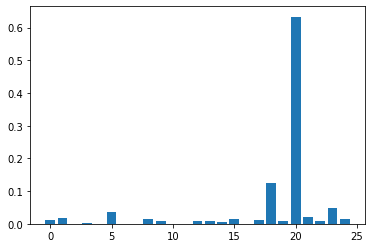

In [ ]:
# plot feature importance:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# checking which feature is the most important according to the decision tree:
df_feature_eng.columns[20]

'attribute1_mov_avg_7'

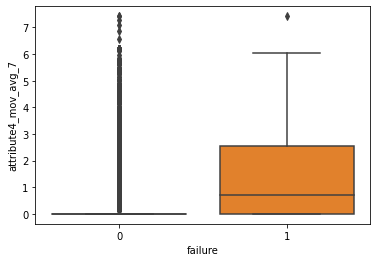

In [ ]:
# checking the difference between the ditribution of this attribute when failure and non-failure:
sns.boxplot(x=df_feature_eng['failure'], y=np.log(df_feature_eng['attribute4_mov_avg_7']+1));

In [ ]:
# checking performance of the train test:
confusion_matrix(y_train, model_tree.predict(X_train))

array([[91558,  1734],
       [ 1503, 91789]])

In [ ]:
# classification report:
print(classification_report(y_train, model_tree.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     93292
           1       0.98      0.98      0.98     93292

    accuracy                           0.98    186584
   macro avg       0.98      0.98      0.98    186584
weighted avg       0.98      0.98      0.98    186584



In [ ]:
# checking performance of the test test:
confusion_matrix(y_test, model_tree.predict(X_test_scaled))

array([[30511,   585],
       [   15,    13]])

In [ ]:
# classification report:
print(classification_report(y_test, model_tree.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31096
           1       0.02      0.46      0.04        28

    accuracy                           0.98     31124
   macro avg       0.51      0.72      0.52     31124
weighted avg       1.00      0.98      0.99     31124



#### 5.2 - Random Forest:

In [ ]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, min_samples_leaf=100)

# doing a cross validation:
cross_val_score(model_forest, X_train, y_train, cv=3, scoring='f1')

array([0.99012689, 0.98973661, 0.98948142])

In [ ]:
# training the model:
model_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=100, random_state=42)

In [ ]:
# checking performance of the train test:
confusion_matrix(y_train, model_forest.predict(X_train))

array([[92372,   920],
       [  262, 93030]])

In [ ]:
# classification report:
print(classification_report(y_train, model_forest.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     93292
           1       0.99      1.00      0.99     93292

    accuracy                           0.99    186584
   macro avg       0.99      0.99      0.99    186584
weighted avg       0.99      0.99      0.99    186584



In [ ]:
# checking performance of the test test:
confusion_matrix(y_test, model_forest.predict(X_test_scaled))

array([[30791,   305],
       [   18,    10]])

In [ ]:
# classification report:
print(classification_report(y_test, model_forest.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     31096
           1       0.03      0.36      0.06        28

    accuracy                           0.99     31124
   macro avg       0.52      0.67      0.53     31124
weighted avg       1.00      0.99      0.99     31124



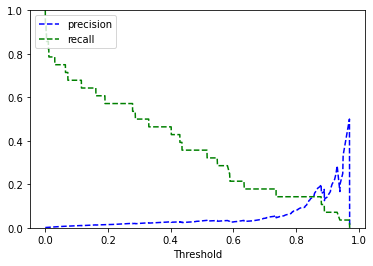

In [ ]:
# checking the precision x recall plot to choose the best threshold:
y_scores = model_forest.predict_proba(X_test_scaled)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1], )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [ ]:
# checking the metrics for the best threshold, based on the plot above (between 0.85 and 0.90):
y_test_pred = model_forest.predict_proba(X_test_scaled)[:,1]
y_test_pred = [1 if x > 0.88 else 0 for x in y_test_pred]

# classification report:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31096
           1       0.20      0.14      0.17        28

    accuracy                           1.00     31124
   macro avg       0.60      0.57      0.58     31124
weighted avg       1.00      1.00      1.00     31124



**Partial results of the model selection:**

Comparing both models that I tested, the Random Forest had a best performance, comparing the **F1-score metric**:
- Decision Tree: 0.06
- Random Forest: 0.17

The performance is not very good yet (F1-score = 0.17 is terrible), but due the limited time, I decided to stop here.
However, having more time, I would continue iterating between the steps, trying to create more healpful variables, trying to use other models, changing the hyperparameters, etc.

### 6 - Conclusion:

- It is important to pay a lot of attention when working with a unbalanced dataset;
- For these cases, choosing the correct performance metric is crucial to able to obtain the desired outcome (example: if accuracy is the chosen metric, the model will have a very high score on train and test, but looking at the precision and recall, it is easy to see that it will have a lot of false positive or a lot of false negatives);
- I have tried only the first 2 types of model (decision tree and random forest) due to the limited time, but the ideal is to continue checking the performance of the other models I listed and some others, before deciding on which model to pick;
- Also, to pick the best combination of hyperparameters for each, it is important to try different ones and evaluate on a separete validation set, beforing evaluating the chosen combination on the test set.

### 7 - Next steps:

There were a lot of things I did not do, due to lack of time, but here is a list of possible next steps and ideas, in case this project continued:

- Create more features from the date variable;
- Create features by composing variables (example: sum of all attributes, one variable multiplied or divided by another, etc);
- Analysing the viability of a time series modeling (one model for all devices or one for each? How to do this kind of thing?);
- Apply hyperparameter tuning techniques to chose the best combination of hyperparameters for each model;
- Try other types of models;
- If using Logistic Regression, check for the assumptions necessary to the residuals of the model (normal distribution, random, independents);
- Iterate through all steps after insights during the process to try to improve the performance of the models on the test set;
- Analyse the tradeoff between precision and recall for different thresholds to mark the probabilities as 1 or 0;
- Try regularization to avoid overfit;
- Use some libraries that help explain how the model is making the predictions, for the models with low explainability;
- Save the chosen model on a file, to be used on future cases.